# Weibull Accelerated Failure Time Models

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
import patsy
import theano.tensor as tt

plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.4.1


Well looks like we're trying a whole lot of stuff here...

In [5]:
print(statsmodels.datasets.get_rdataset(package='survival', dataname='flchain').__doc__)

+---------+-----------------+
| flchain | R Documentation |
+---------+-----------------+

Assay of serum free light chain for 7874 subjects.
--------------------------------------------------

Description
~~~~~~~~~~~

This is a stratified random sample containing 1/2 of the subjects from a
study of the relationship between serum free light chain (FLC) and
mortality. The original sample contains samples on approximately 2/3 of
the residents of Olmsted County aged 50 or greater.

Usage
~~~~~

::

    data(flchain)

Format
~~~~~~

A data frame with 7874 persons containing the following variables.

``age``
    age in years

``sex``
    F=female, M=male

``sample.yr``
    the calendar year in which a blood sample was obtained

``kappa``
    serum free light chain, kappa portion

``lambda``
    serum free light chain, lambda portion

``flc.grp``
    the FLC group for the subject, as used in the original analysis

``creatinine``
    serum creatinine

``mgus``
    1 if the subject had been di

In [6]:
# Fetch and clean data
data = (statsmodels.datasets
                   .get_rdataset(package='survival', dataname='flchain')
                   .data
                   .query('futime > 7')  # Maybe we can remove this?
                   .sample(500)
                   .reset_index(drop=True))

In [7]:
data.head()

,age,sex,sample.yr,kappa,lambda,flc.grp,creatinine,mgus,futime,death,chapter
0,60,M,2002,1.02,1.12,3,NaN,0,2532,0,NaN
1,86,F,1996,1.66,1.33,6,1.2,0,4624,0,NaN
2,53,M,2003,1.47,1.22,5,NaN,0,2238,0,NaN
3,62,M,1998,3.84,3.34,10,1.1,0,1108,1,Neoplasms
4,77,M,1996,3.62,7.06,10,0.9,0,41,1,Mental


In [33]:
# Get matrices of covariates from dataframe using patsy
_, X_df = patsy.dmatrices("death ~ age + sex", data, return_type='dataframe')
X_df = X_df.iloc[:, X_df.columns != 'Intercept']

X = X_df.values
y = data.futime.values
death = data['death'].values

In [25]:
#N, M = X.shape
num_obs, num_feats = X.shape

## Model 1

In [62]:
sd_mu = 10.0
sd_al = 10.0


def weibull_lccdf(value, alpha, beta):
    return - (value / beta)**alpha


with pm.Model() as weibull:
    beta_raw = pm.Normal('b0', mu=0, sd=1, shape=num_feats)
    alpha_raw = pm.Normal('a0', mu=0, sd=0.1)
    mu = pm.Normal('mu', mu=0., sd=sd_mu)

    tau_s_raw = pm.HalfNormal('tau_s_raw', sd=10)
    tau_raw = pm.ChiSquared('tau_raw', nu=1, shape=num_feats)
    beta = pm.Deterministic('beta', tau_s_raw * tt.sqrt(1. / tau_raw) * beta_raw)

    alpha = pm.Deterministic('alpha', tt.exp(sd_al * alpha_raw))

    lp = mu + tt.dot(X, beta)

    y1 = pm.Weibull(
        'y1', alpha, tt.exp(-(lp[death == 1]) / alpha), observed=y[death == 1]
    )
    y0 = pm.Potential(
        'y0', weibull_lccdf(y[death == 0],
                            alpha,
                            tt.exp(-(lp[death == 0]) / alpha))
    )

In [63]:
with weibull:
    trace = pm.sample(init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau_raw, tau_s_raw, mu, a0, b0]
Sampling 2 chains: 100%|██████████| 2000/2000 [01:20<00:00, 10.18draws/s]
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


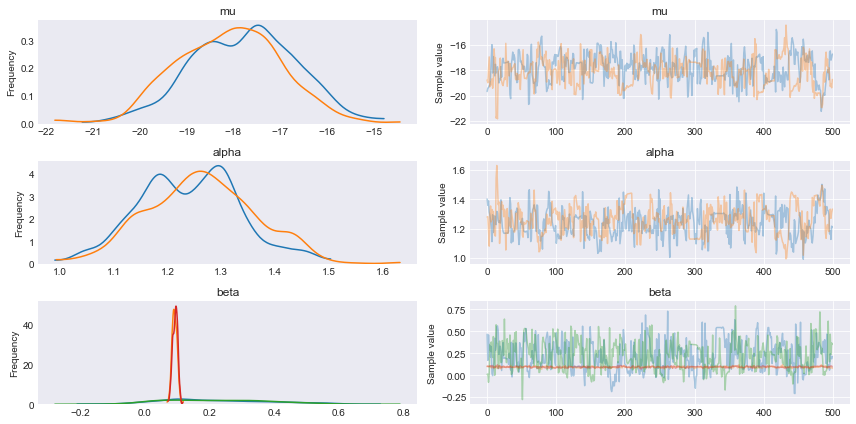

In [64]:
pm.traceplot(trace, 
             varnames=['mu','alpha', 'beta']);

## Model 2

[Weibull Survival Regression](https://discourse.pymc.io/t/weibull-survival-regression-aft/1107/3)

In [44]:
sd_mu = 100.0
sd_al = 10.0


def weibull_lccdf(value, alpha, beta):
    return - (value / beta)**alpha


with pm.Model() as weibull:
    alpha_raw = pm.Normal('a0', mu=0., sd=.1)
    mu = pm.Normal('mu', mu=0., sd=sd_mu)

    alpha = pm.Deterministic('alpha', tt.exp(sd_al * alpha_raw))
    beta = pm.Deterministic('beta', tt.exp(mu / alpha))
    
    y1 = pm.Weibull(
        'y1', alpha, beta, observed=y[death == 1])
    y0 = pm.Potential(
        'y0', weibull_lccdf(y[death == 0], alpha, beta))
    
    trace = pm.sample(init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, a0]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:03<00:00, 661.37draws/s]
The acceptance probability does not match the target. It is 0.9177096990889461, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8997758852652467, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


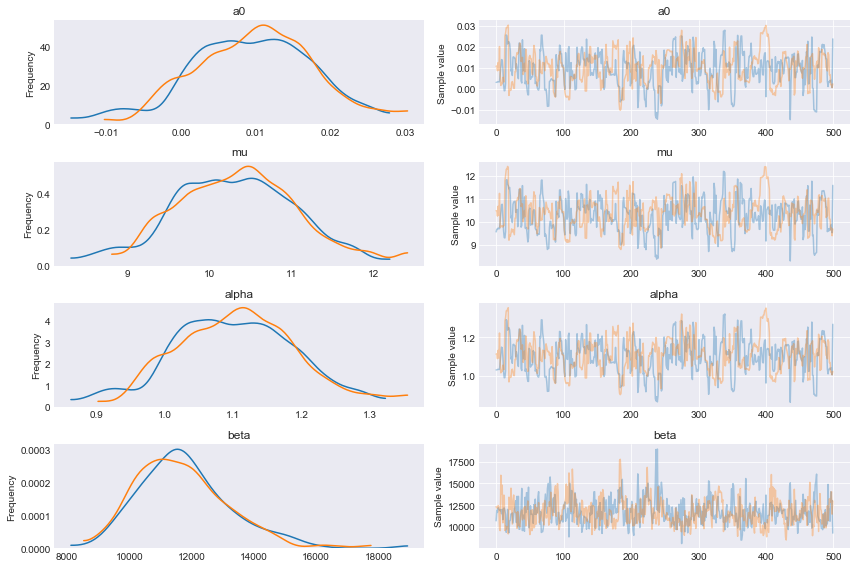

In [45]:
pm.traceplot(trace);

In [47]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a0,0.009600,0.008072,0.000522,-0.005687,0.026066,209.315870,1.002935
mu,10.331593,0.738191,0.047290,8.830600,11.752220,213.219671,1.002997
alpha,1.104338,0.088854,0.005738,0.939184,1.291733,209.819001,1.002721
beta,11734.988651,1475.634392,80.170477,9233.870451,14729.217755,284.103913,0.999956


## Model 3

https://github.com/stan-dev/example-models/blob/master/bugs_examples/vol1/kidney/kidney.stan

In [48]:
with pm.Model() as m:
    alpha = pm.Normal('alpha', 0., 10.)
    r = pm.Gamma('r', 1., .001, testval=.25)
    beta = pm.Deterministic('beta', tt.exp(-alpha / r))
    y1 = pm.Weibull(
        'y1', r, beta, observed=time[event == 1])
    y0 = pm.Bernoulli(
        'y0', tt.exp(-tt.pow(y[death == 0] / beta, r)),
         observed=np.ones(np.sum(death == 0)))
#     y0 = pm.Potential(
#         'y0', weibull_lccdf(time[event == 0], r, beta))

In [53]:
with m:
    tr = pm.sample(init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [r, alpha]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:10<00:00, 191.26draws/s]
The acceptance probability does not match the target. It is 0.9789369192115801, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


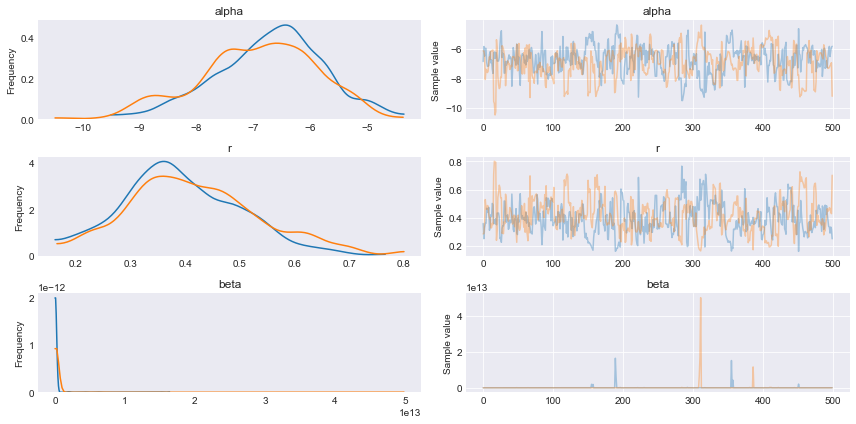

In [54]:
pm.traceplot(tr);

In [55]:
pm.summary(tr)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-6.832672e+00,9.955598e-01,6.311798e-02,-8.951373,-5.049870e+00,128.629776,1.012372
r,4.064181e-01,1.142228e-01,7.225611e-03,0.193375,6.362477e-01,126.775815,1.011816
beta,1.364620e+11,1.870947e+12,7.208940e+10,186718.608846,1.638337e+10,554.465761,0.999402


## Model 4

http://austinrochford.com/posts/2017-10-02-bayes-param-survival.html

In [58]:
logtime = np.log(y)

def gumbel_sf(y, mu, sigma):
    return 1.0 - tt.exp(-tt.exp(-(y - mu) / sigma))


# Build Bayesian model
with pm.Model() as model:
    # Hyperprior
    s = pm.HalfNormal("s", tau=5.0)

    # Priors
    gamma = pm.Normal("gamma", 0., 5.0)

    # Likelihood for uncensored and censored survival times
    y_obs = pm.Gumbel("y_obs", mu=gamma, beta=s, observed=logtime[death == 1])
    y_cens = pm.Bernoulli("y_cens", p=gumbel_sf(
        logtime[death == 0], mu=gamma, sigma=s), observed=np.ones(np.sum(death == 0)))

    trace = pm.sample(1000, tune=1000, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/george/.theano/compiledir_Darwin-17.5.0-x86_64-i386-64bit-i386-3.6.5-64/lock_dir/lock
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [gamma, s]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1909.36draws/s]


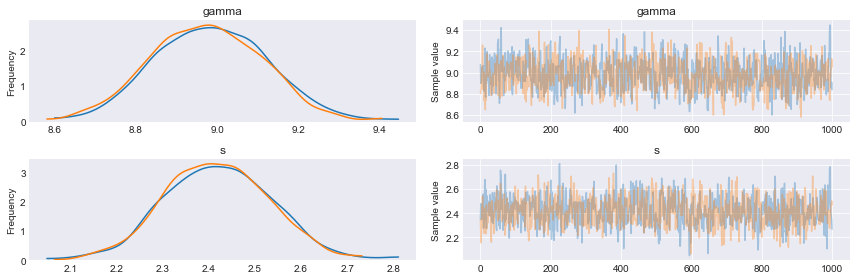

In [59]:
pm.traceplot(trace);

In [60]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
gamma,8.978448,0.138858,0.004400,8.705671,9.245324,878.124998,1.002480
s,2.417379,0.114010,0.003706,2.195171,2.636063,921.795656,1.000059
